In [84]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
#from sklearn.cross_validation import KFold   sklearn.cross_validation is now changed to sklearn.model_selection
from sklearn.model_selection import KFold


In [85]:
# Load in the train and test datasets
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [86]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)

In [87]:
train.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Name_length'],
      dtype='object')

In [88]:
train[['Ticket', 'Name_length']]

,Ticket,Name_length
0,A/5 21171,23
1,PC 17599,51
2,STON/O2. 3101282,22
3,113803,44
4,373450,24
...,...,...
886,211536,21
887,112053,28
888,W./C. 6607,40
889,111369,21


In [89]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [90]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [91]:

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1




In [92]:
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')


In [93]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    


In [104]:
train['Fare']

0       7.2500
1      71.2833
2       7.9250
3      53.1000
4       8.0500
        ...   
886    13.0000
887    30.0000
888    23.4500
889    30.0000
890     7.7500
Name: Fare, Length: 891, dtype: float64

In [111]:
type( full_data[0] )

pandas.core.frame.DataFrame

In [95]:
#pd.qcut(train['Fare'], 4)
#You can drop duplicate edges by setting the 'duplicates' kwarg

train['CategoricalFare'] = pd.qcut(train['Fare'], 4,duplicates='drop')

In [97]:

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#(1) pd.cut()으로 동일 길이로 나누어서 범주를 만든 후 GroupBy()로 그룹별 통계량 구하기
#(2) pd.qcut()으로 동일 개수로 나누어서 범주를 만든 후 GroupBy()로 그룹별 통계량 구하기

train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [98]:
pd.cut(train['Age'], 5)

0      (16.0, 32.0]
1      (32.0, 48.0]
2      (16.0, 32.0]
3      (32.0, 48.0]
4      (32.0, 48.0]
           ...     
886    (16.0, 32.0]
887    (16.0, 32.0]
888    (16.0, 32.0]
889    (16.0, 32.0]
890    (16.0, 32.0]
Name: Age, Length: 891, dtype: category
Categories (5, interval[float64]): [(-0.08, 16.0] < (16.0, 32.0] < (32.0, 48.0] < (48.0, 64.0] < (64.0, 80.0]]

In [99]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


In [100]:
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [102]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


In [115]:
full_data
full_data[0]
type(full_data[0])
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,NaN,Q,16,0,1,1,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,NaN,S,32,0,2,0,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,NaN,Q,25,0,1,1,Mr
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,NaN,S,16,0,1,1,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,NaN,S,44,0,3,0,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,32,0,0,A.5. 3236,8.0500,NaN,S,18,0,1,1,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39,0,0,PC 17758,108.9000,C105,C,28,1,1,1,Rare
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,28,0,1,1,Mr
416,1308,3,"Ware, Mr. Frederick",male,20,0,0,359309,8.0500,NaN,S,19,0,1,1,Mr


In [114]:
dataset['Sex'].map( {'female': 0, 'male': 1, 0:0, 1:1} )

0      1
1      0
2      1
3      1
4      0
      ..
413    1
414    0
415    1
416    1
417    1
Name: Sex, Length: 418, dtype: int64

In [116]:

    

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1, 0:0, 1:1} )
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5
                     ,1: 1, 2 : 2, 3: 3, 4: 4, 5 : 5 
                     }
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2
                                                    , 0 : 0 , 1 : 1, 2 : 2
                                                   } ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [122]:
type(full_data)

list

In [124]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
drop_elements

['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']

In [125]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

KeyError: "['PassengerId' 'Name' 'Ticket' 'Cabin' 'SibSp'] not found in axis"

In [128]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [130]:
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

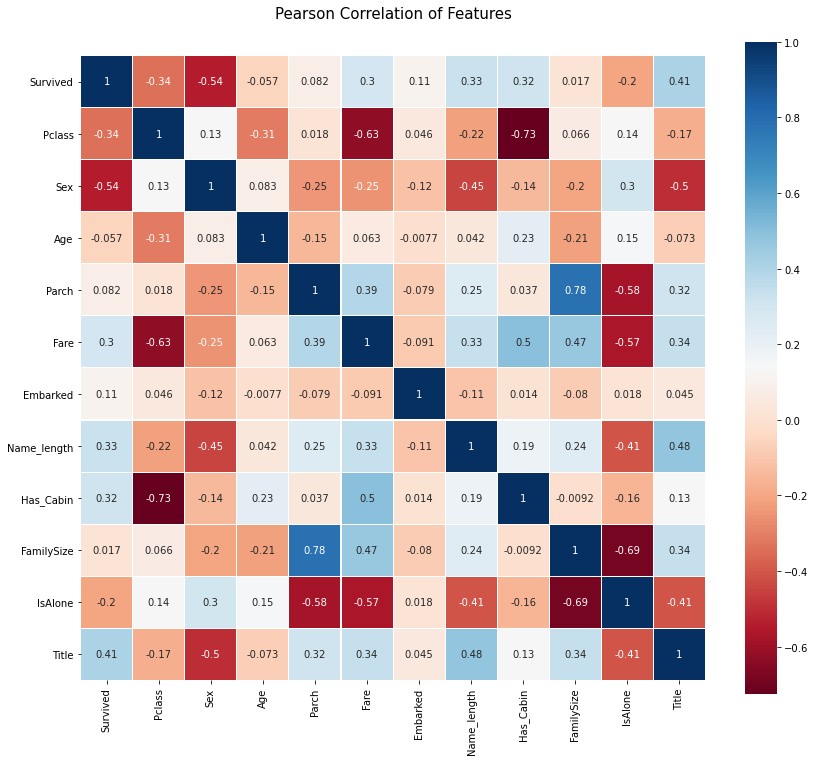

In [132]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

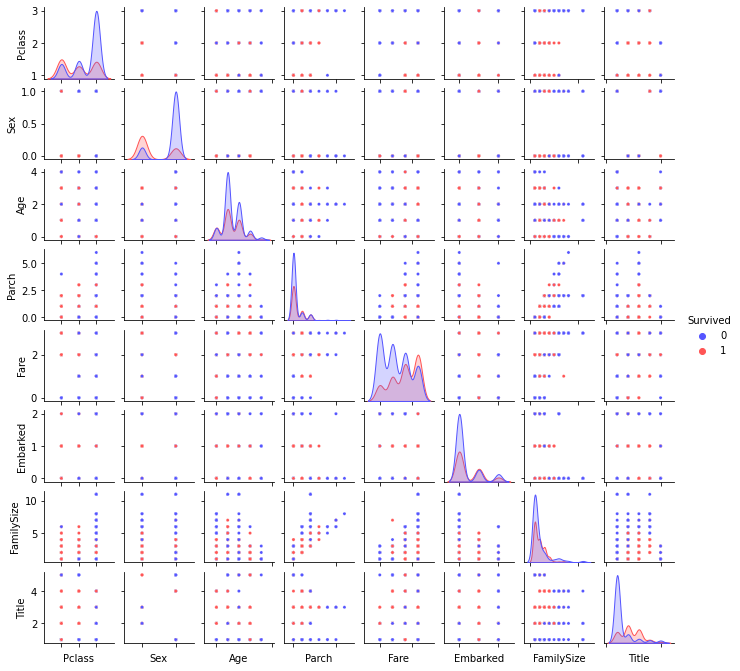

In [133]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])